In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import fastai
import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error
import pickle as pkl
from tqdm import tqdm
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.theta import ThetaModel

ModuleNotFoundError: No module named 'statsmodels.tsa.forecasting'

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
oex_tickers = ["AAPL", "ABBV", "ABT", "ACN","ADBE","AIG", "ALL", "AMGN", "AMT", "AMZN", "AXP", "BA", "BAC","BIIB","BK","BKNG","BLK","BMY","C","CAT","CHTR","CL","CMCSA","COF","COP","COST","CRM","CSCO","CVS","CVX","DD","DHR","DIS","DUK","EMR","EXC","F","FB","FDX","GD","GE","GILD","GM","GOOG","GOOGL","GS","HD","HON","IBM","INTC","JNJ","JPM","KHC","KMI","KO","LLY","LMT","LOW","MA","MCD","MDLZ","MDT","MET","MMM","MO","MRK","MS","MSFT","NEE","NFLX","NKE","NVDA","ORCL","OXY","PEP","PFE","PG","PM","PYPL","QCOM","RTX","SBUX","SLB","SO","SPG","T","TGT","TMO","UNH","UNP","UPS","USB","V","VZ","WBA","WFC","WMT","XOM"]

In [4]:
training_data = pd.read_pickle("data_dump/training_oex_5y_data.pkl")
training_data = training_data.drop(["OW", "BRK.B", "XN"])

FileNotFoundError: [Errno 2] No such file or directory: 'data_dump/training_oex_5y_data.pkl'

In [5]:
from utils.general import training_data_for_t
from sklearn.linear_model import SGDRegressor
import time
from core import Position, PositionType
from utils.general import change_above_threshold

def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
#         print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
#         print(log) if verbose else None

    return updated_balance

def simulate_trades_returns(predictions, ground_truth, thresholds=None, slowed=False, verbose=False, print_result = False):
#     print(len(thresholds), len(ground_truth))
    assert len(thresholds) == len(ground_truth)
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 0
    position = None
    n_trades = 0
    
    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None
#         if next_prediction == -1:
#             continue
        if next_prediction > 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif next_prediction < 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None
        
            
        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log) if print_result else None

    return balance_over_time

ModuleNotFoundError: No module named 'utils'

In [6]:
import time
from core import Position, PositionType
from utils.general import change_above_threshold

"""
Liquidates a given Position and returns the new balance
"""


def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
        print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
        print(log) if verbose else None

    return updated_balance


"""
Simulation in format of:
    - If open position -> close by selling or buying back
    - Decide on next position
    - Repeat

Decisions to buy / sell happen continuously each day
"""


def simulate_trades_prices(predictions, ground_truth, thresholds=0, slowed=False, verbose=False):
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 0
    position = None
    n_trades = 0

    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None

        if curr_price < next_prediction:
            # check threshold
            if change_above_threshold(curr_price, next_prediction, threshold=thresholds[t]):
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif curr_price > next_prediction:
            # check threshold
            if change_above_threshold(curr_price, next_prediction, threshold=thresholds[t]):
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log)

    return balance_over_time

ModuleNotFoundError: No module named 'core'

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


def fit_base_ensemble(models, X_train, X_val, y_train, y_val):
    meta_X = list()
    for name, model in models:
        model.fit(X_train, y_train)
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
#     blender.fit(meta_X, y_val)
    return meta_X

def predict_base_ensemble(models, X_val):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return meta_X

def fit_meta_ensemble(meta_X, y_val, meta_model):
    meta_model.fit(meta_X, y_val)
    return meta_model

def fit_full_ensemble(models, X_train, X_val, y_train, y_val, meta_model):
    meta = fit_base_ensemble(models, X_train, X_val, y_train, y_val)
    return fit_meta_ensemble(meta, y_val, meta_model)


def predict_ensemble(models, blender, X_test):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_test)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return blender.predict(meta_X)

In [8]:
from methods.svm import SVM
from preparers import ticker_default
from core.functions import forecast
from core.simulation import simulate_trades_continuous
from utils.viz import plot_time_series, plot_balance, plot_balance_vs_price
from utils.general import differentiate, inv_differentiate

ModuleNotFoundError: No module named 'methods'

# New Ensemble

Use AR1, Theta, ARIMA, and RandomForestRegressor as base models

SGD (Linear Regressor) and RandomForestRegressor as meta models

Run base models individually and have their simulation results

Combine the prediction arrays from those runs and run the meta model simulations

Do the above for 6 stocks

## AR1

 30%|██▉       | 262/878 [00:00<00:00, 1265.19it/s]

Predicting with no thresholding


100%|██████████| 878/878 [00:00<00:00, 1422.20it/s]


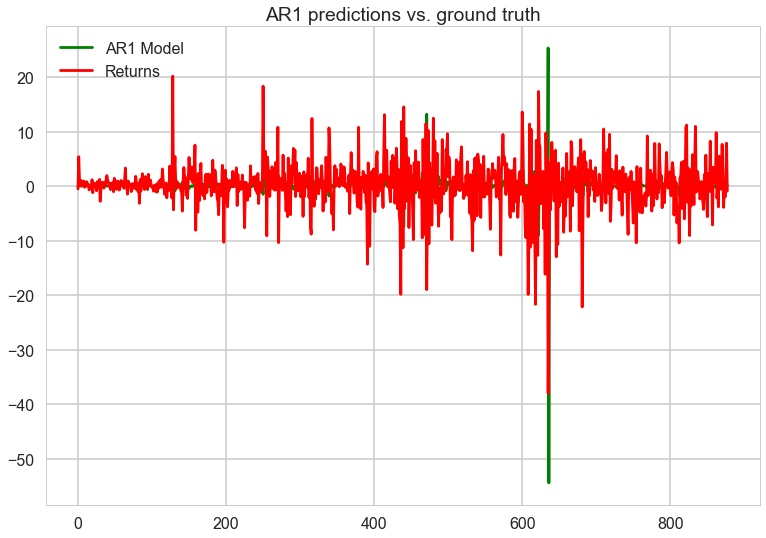

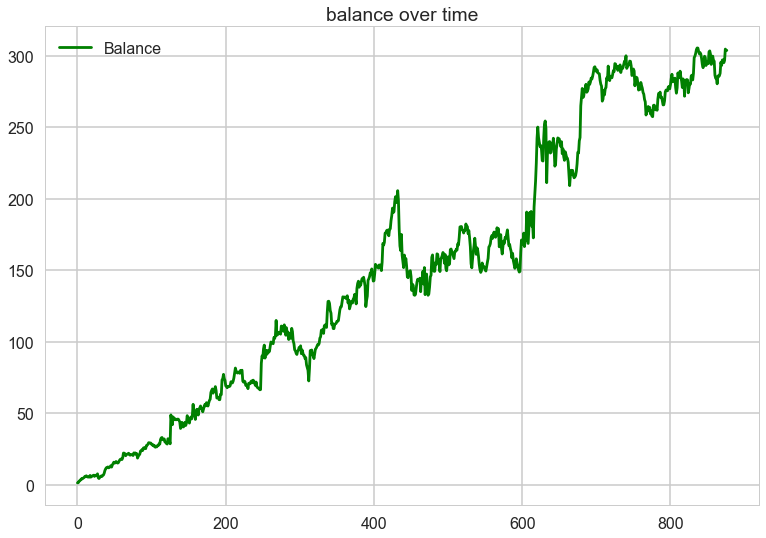

In [81]:
first_df = training_data.loc["NVDA"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
assert len(x_features) == len(y_features)
predictions_ar1 = []

thresholds = []
base_training_X = x_features[:start_t].reset_index(drop=True)
base_training_y = y_features[:start_t].reset_index(drop=True)
base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

ar1 = SGDRegressor(shuffle=False, learning_rate='adaptive', eta0=0.002)
ar1.partial_fit(base_training_X, base_training_y)
print("Predicting with no thresholding")
for t_i in tqdm(range(len(y_features) - start_t)):
    current_t = t_i + start_t
    threshold = 0
    thresholds.append(threshold)
    predictions_ar1.append(ar1.predict([x_features.iloc[current_t]]))
    ar1.partial_fit([x_features.iloc[current_t]], [y_features.iloc[current_t]])
    

balances_ar1 = simulate_trades_returns(predictions_ar1, ground_truth[start_t:], thresholds)

plot_time_series(ts_1=predictions_ar1, ts_label_1='AR1 Model', ts_2=x_features[start_t:], ts_label_2='Returns', title='AR1 predictions vs. ground truth')

plot_balance(data=balances_ar1)

# ARIMA

In [64]:
# first_df = training_data.loc["NVDA"].dropna()

# data = first_df.reset_index(drop=True)
# data = data[1:len(data)-1].to_numpy()

# num_days_year = 253

# ground_truth, start_t = data, int(num_days_year/2)

# predictions_arima = list()
# thresholds = []
# training_X = data[:start_t]

# test_X = data[start_t:]

# print("Predicting ARIMA with no thresholding")
# for t_i in tqdm(range(len(data) - start_t)):
#     current_t = t_i + start_t
#     threshold = 0
#     thresholds.append(threshold)
#     model = ARIMA(data[t_i:current_t], order = (5,1,0))
#     fitted_model = model.fit()
#     prediction = fitted_model.forecast()
#     predictions_arima.append(prediction[0])

# print("RMSE of forecasting: ", sqrt(mean_squared_error(test_X, predictions_arima)))
# balances_arima = simulate_trades_prices(predictions_arima, ground_truth[start_t:], thresholds)

# plot_time_series(ts_1=predictions_arima, ts_label_1='Vanilla ARIMA Model', ts_2=first_df[start_t:], ts_label_2='Close', title='ARIMA predictions vs. ground truth')
# plot_balance(data=balances_arima)


  0%|          | 3/878 [00:00<00:35, 24.77it/s]

Predicting ARIMA with no thresholding


100%|██████████| 878/878 [00:30<00:00, 28.69it/s]

RMSE of forecasting:  4.890442328593895
Simulation done. Executed 877 trades, Final Balance: 5.889797210693359


AssertionError: 

  0%|          | 2/878 [00:00<00:59, 14.82it/s]

Predicting with no thresholding


100%|██████████| 878/878 [01:41<00:00,  8.64it/s]


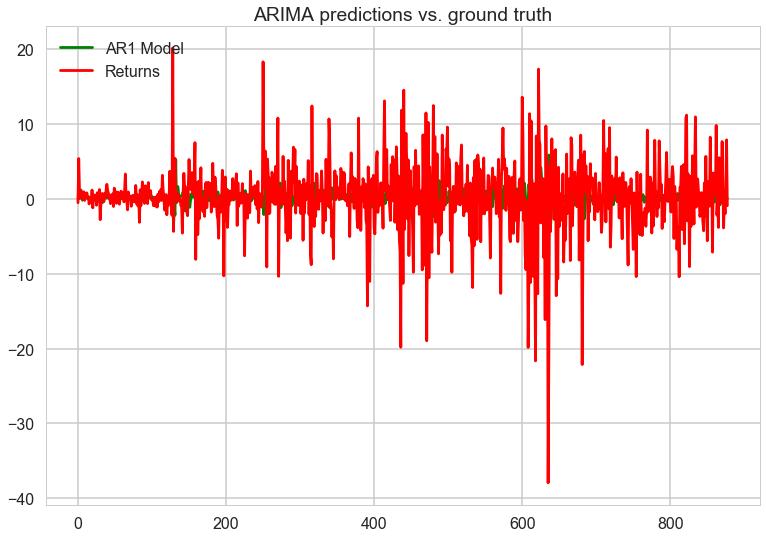

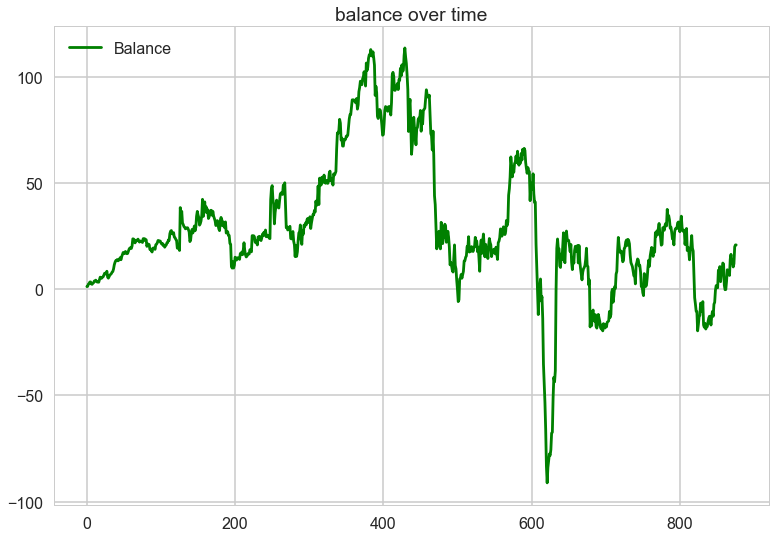

In [65]:
first_df = training_data.loc["NVDA"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
assert len(x_features) == len(y_features)
predictions_arima = []

thresholds = []
base_training_X = x_features[:start_t].reset_index(drop=True)
base_training_y = y_features[:start_t].reset_index(drop=True)
base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)


print("Predicting with no thresholding")
for t_i in tqdm(range(len(y_features) - start_t)):
    current_t = t_i + start_t
    threshold = 0
    thresholds.append(threshold)
    model = ARIMA(x_features[:current_t], order = (5,0,0))
    fitted_model = model.fit()
    prediction = fitted_model.forecast().reset_index(drop=True)
    predictions_arima.append(prediction[0])
    

balances_arima = simulate_trades_returns(predictions_arima, ground_truth[start_t:], thresholds)

plot_time_series(ts_1=predictions_arima, ts_label_1='AR1 Model', ts_2=x_features[start_t:], ts_label_2='Returns', title='ARIMA predictions vs. ground truth')

plot_balance(data=balances_arima)

# Theta

  1%|          | 7/878 [00:00<00:13, 62.67it/s]

Predicting with no thresholding


100%|██████████| 878/878 [00:18<00:00, 48.15it/s]


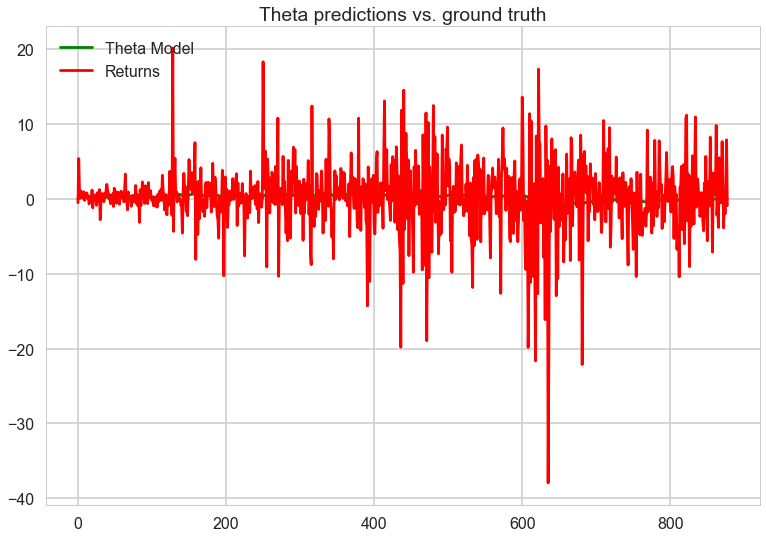

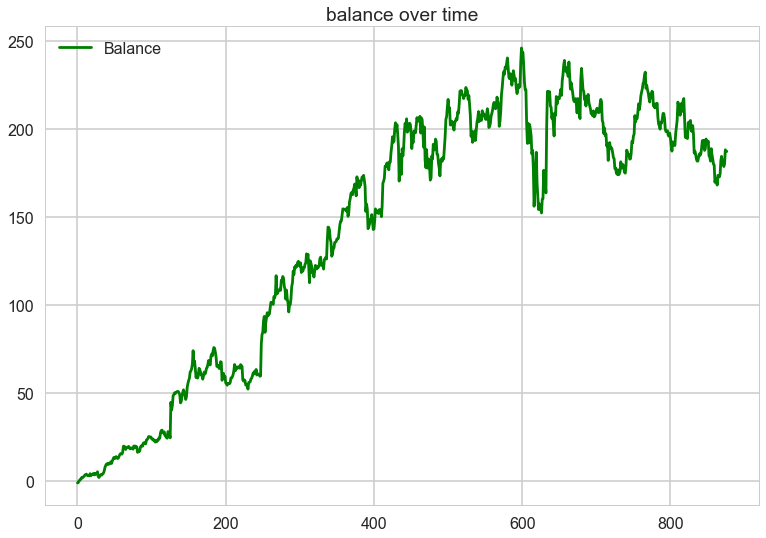

In [41]:
first_df = training_data.loc["NVDA"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
assert len(x_features) == len(y_features)
predictions_theta_returns = []

thresholds = []
base_training_X = x_features[:start_t].reset_index(drop=True)
base_training_y = y_features[:start_t].reset_index(drop=True)
base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)


print("Predicting with no thresholding")
for t_i in tqdm(range(len(y_features) - start_t)):
    current_t = t_i + start_t
    threshold = 0
    thresholds.append(threshold)
    model = ThetaModel(y_features[:current_t],deseasonalize=False)
    fitted_model = model.fit()
    prediction = fitted_model.forecast().reset_index(drop=True)
    predictions_theta_returns.append(prediction[0])
    

balances_theta_returns = simulate_trades_returns(predictions_theta_returns, ground_truth[start_t:], thresholds)

plot_time_series(ts_1=predictions_theta_returns, ts_label_1='Theta Model', ts_2=x_features[start_t:], ts_label_2='Returns', title='Theta predictions vs. ground truth')

plot_balance(data=balances_theta_returns)

# RandomForestRegressor

  0%|          | 1/878 [00:00<01:29,  9.77it/s]

Predicting with no thresholding


100%|██████████| 878/878 [02:38<00:00,  5.54it/s]


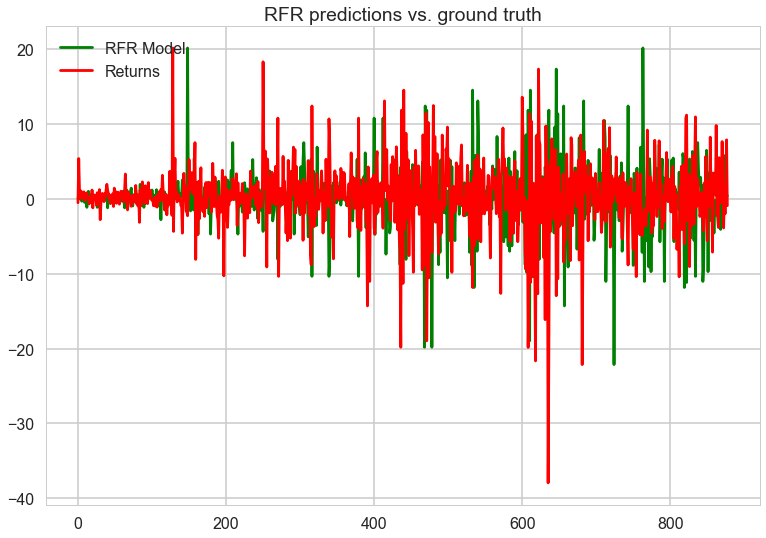

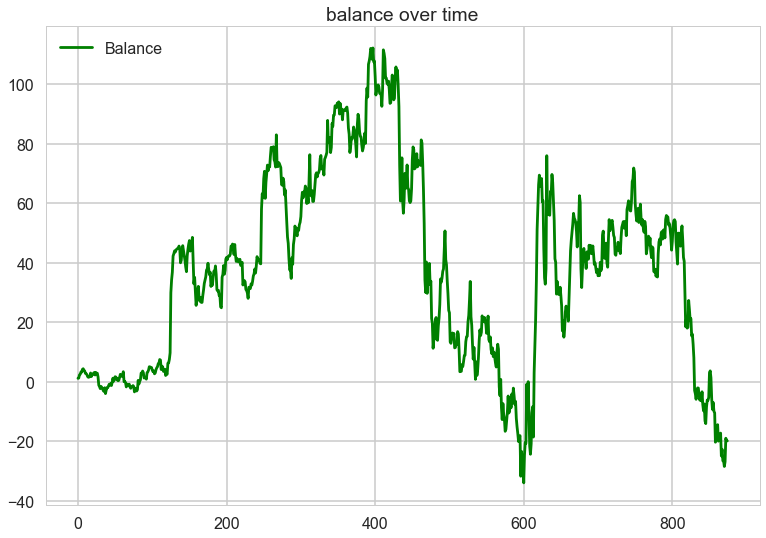

In [82]:
first_df = training_data.loc["NVDA"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
assert len(x_features) == len(y_features)
predictions_rfr = []

thresholds = []
base_training_X = x_features[:start_t].reset_index(drop=True)
base_training_y = y_features[:start_t].reset_index(drop=True)
base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

rfr = RandomForestRegressor(bootstrap=False)
rfr.fit(base_training_X, base_training_y)
print("Predicting with no thresholding")
for t_i in tqdm(range(len(y_features) - start_t)):
    current_t = t_i + start_t
    threshold = 0
    thresholds.append(threshold)
    rfr.fit(x_features[:current_t].to_numpy(), y_features[:current_t].to_numpy())
    predictions_rfr.append(rfr.predict([x_features.iloc[current_t]]))

balances_rfr = simulate_trades_returns(predictions_rfr, ground_truth[start_t:], thresholds)

plot_time_series(ts_1=predictions_rfr, ts_label_1='RFR Model', ts_2=x_features[start_t:], ts_label_2='Returns', title='RFR predictions vs. ground truth')

plot_balance(data=balances_rfr)

# Ensemble

# Linear Regression

100%|██████████| 752/752 [00:00<00:00, 2083.97it/s]


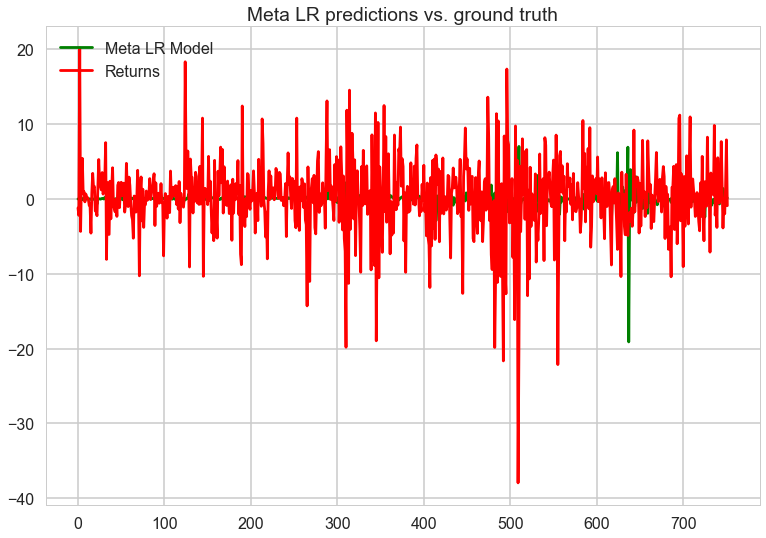

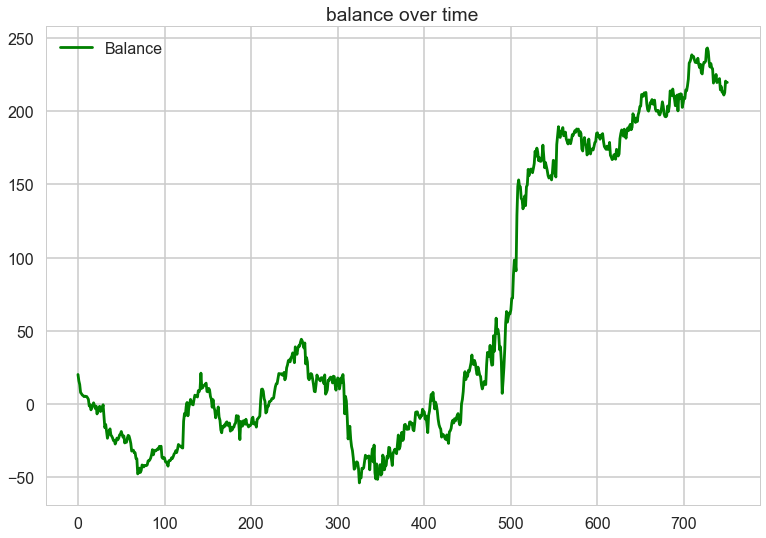

In [78]:
first_df = training_data.loc["NVDA"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
assert len(x_features) == len(y_features)
thresholds = []
meta_model_lr = SGDRegressor(fit_intercept=False)

# returns_arima = np.subtract(predictions_arima, data[start_t:].reset_index(drop=True))
all_predictions = [predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns]
meta_X = []
for i in range(start_t):
    meta_X_instance = [all_predictions[0][i][0], all_predictions[1][i], all_predictions[2][i][0], all_predictions[3][i]]
    meta_X.append(meta_X_instance)
    
meta_model_lr.partial_fit(meta_X, y_features[start_t:start_t*2])
predictions_meta_lr = []
for t_i in tqdm(range(len(y_features) - start_t*2)):
    current_t = t_i + start_t
    threshold = 0
    thresholds.append(threshold)
    prediction = meta_model_lr.predict([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]])
    predictions_meta_lr.append(prediction)
    meta_model_lr.partial_fit([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]], [y_features.iloc[current_t]])


balances_meta_lr = simulate_trades_returns(predictions_meta_lr, ground_truth[start_t*2:], thresholds)

plot_time_series(ts_1=predictions_meta_lr, ts_label_1='Meta LR Model', ts_2=x_features[start_t*2:], ts_label_2='Returns', title='Meta LR predictions vs. ground truth')

plot_balance(data=balances_meta_lr)

# Random Forest Regressor Meta Model

100%|██████████| 752/752 [04:44<00:00,  2.64it/s]


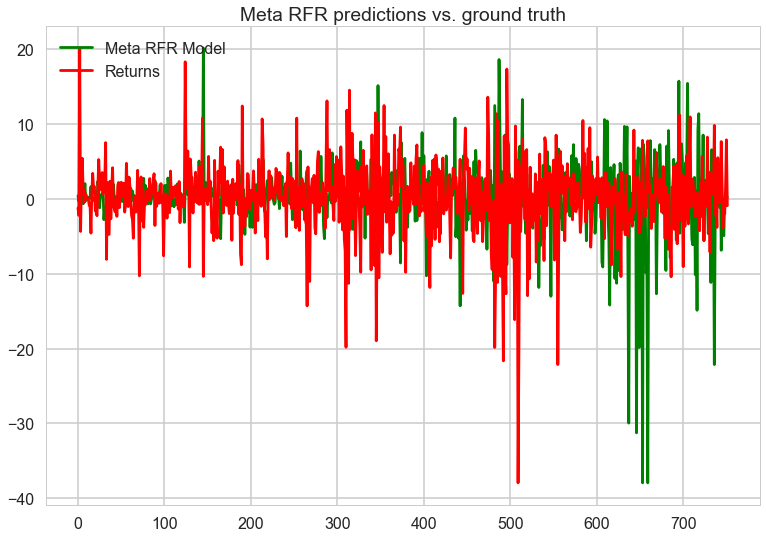

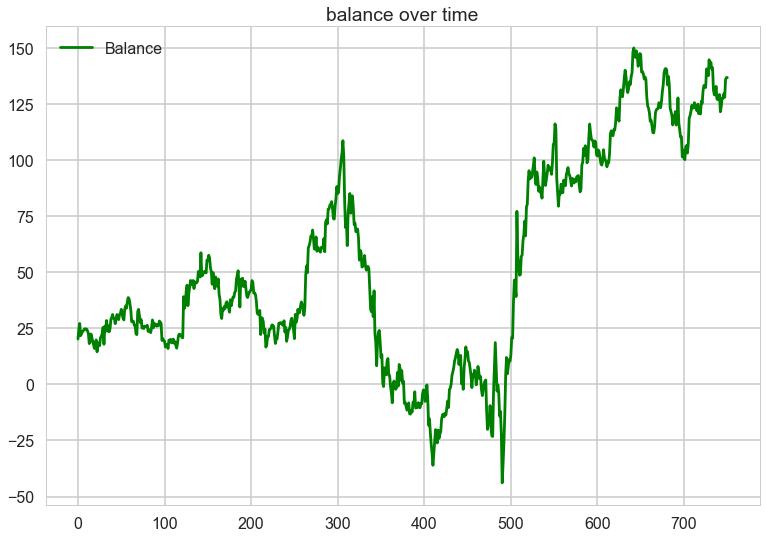

In [79]:
first_df = training_data.loc["NVDA"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
assert len(x_features) == len(y_features)
thresholds = []
meta_model_rfr = RandomForestRegressor(bootstrap=False)

# returns_arima = np.subtract(predictions_arima, data[start_t:].reset_index(drop=True))
all_predictions = [predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns]
meta_X = []
for i in range(start_t):
    meta_X_instance = [all_predictions[0][i][0], all_predictions[1][i], all_predictions[2][i][0], all_predictions[3][i]]
    meta_X.append(meta_X_instance)
    
meta_model_rfr.fit(meta_X, y_features[start_t:start_t*2])
predictions_meta_rfr = []
for t_i in tqdm(range(len(y_features) - start_t*2)):
    current_t = t_i + start_t
    threshold = 0
    thresholds.append(threshold)
    meta_model_rfr.fit(meta_X, y_features[:current_t])
    meta_X.append([all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]])
    prediction = meta_model_rfr.predict([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]])
    predictions_meta_rfr.append(prediction)
    
    


balances_meta_rfr = simulate_trades_returns(predictions_meta_rfr, ground_truth[start_t*2:], thresholds)

plot_time_series(ts_1=predictions_meta_rfr, ts_label_1='Meta RFR Model', ts_2=x_features[start_t*2:], ts_label_2='Returns', title='Meta RFR predictions vs. ground truth')

plot_balance(data=balances_meta_rfr)

# 6 stocks, diff meta models, same methodology as above

In [80]:
specified_tickers = ["NVDA", "PYPL", "HON", "XOM", "GS", "JPM"]
num_simulations = 10

In [97]:

for ticker in tqdm(specified_tickers):
    print(ticker)
#     vanilla_results[ticker] = {}
#     vanilla_results[ticker]["lr"] = []
#     vanilla_results[ticker]["rfr"] = []
    vanilla_results[ticker]["ar1"] = []
#     vanilla_results[ticker]["lr_weights"] = []
#     vanilla_results[ticker]["arima"] = []
#     vanilla_results[ticker]["rfr_base"] = []
#     vanilla_results[ticker]["theta"] = []
    vanilla_results[ticker]["ar1_lr"] = []
    for i in tqdm(range(num_simulations)):
        #AR1
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_ar1 = []

        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

        ar1 = SGDRegressor(shuffle=False, learning_rate='adaptive', eta0=0.002)
        ar1.partial_fit(base_training_X, base_training_y)
#         print("Predicting with no thresholding")
        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            predictions_ar1.append(ar1.predict([x_features.iloc[current_t]]))
            ar1.partial_fit([x_features.iloc[current_t]], [y_features.iloc[current_t]])


        balances_ar1 = simulate_trades_returns(predictions_ar1, ground_truth[start_t:], thresholds)
        vanilla_results[ticker]["ar1"].append(balances_ar1[len(balances_ar1)-1])
        #AR1-Linear Regression not Stochastic
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_ar1_lr = []

        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

        ar1_lr = LinearRegression()
        ar1_lr.fit(base_training_X, base_training_y)
#         print("Predicting with no thresholding")
        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            predictions_ar1_lr.append(ar1_lr.predict([x_features.iloc[current_t]]))
            ar1_lr = LinearRegression()
            ar1_lr.fit(x_features[:current_t].to_numpy(), y_features[:current_t].to_numpy())


        balances_ar1_lr = simulate_trades_returns(predictions_ar1_lr, ground_truth[start_t:], thresholds)
        vanilla_results[ticker]["ar1_lr"].append(balances_ar1_lr[len(balances_ar1_lr)-1])
        
#         #ARIMA
#         first_df = training_data.loc[ticker].dropna()
#         y_past = first_df[0:first_df.shape[0]-1]
#         y_current = first_df[1:first_df.shape[0]]
#         y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
#         x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
#         y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

#         num_days_year = 253

#         ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
#         assert len(x_features) == len(y_features)
#         predictions_arima = []

#         thresholds = []
#         base_training_X = x_features[:start_t].reset_index(drop=True)
#         base_training_y = y_features[:start_t].reset_index(drop=True)
#         base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
#         base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)


# #         print("Predicting with no thresholding")
#         for t_i in (range(len(y_features) - start_t)):
#             current_t = t_i + start_t
#             threshold = 0
#             thresholds.append(threshold)
#             model = ARIMA(x_features[:current_t], order = (5,0,0))
#             fitted_model = model.fit()
#             prediction = fitted_model.forecast().reset_index(drop=True)
#             predictions_arima.append(prediction[0])


#         balances_arima = simulate_trades_returns(predictions_arima, ground_truth[start_t:], thresholds)
#         vanilla_results[ticker]["arima"].append(balances_arima[len(balances_arima)-1])

#         #Theta
#         first_df = training_data.loc[ticker].dropna()
#         y_past = first_df[0:first_df.shape[0]-1]
#         y_current = first_df[1:first_df.shape[0]]
#         y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
#         x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
#         y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

#         num_days_year = 253

#         ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
#         assert len(x_features) == len(y_features)
#         predictions_theta_returns = []

#         thresholds = []
#         base_training_X = x_features[:start_t].reset_index(drop=True)
#         base_training_y = y_features[:start_t].reset_index(drop=True)
#         base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
#         base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)


# #         print("Predicting with no thresholding")
#         for t_i in (range(len(y_features) - start_t)):
#             current_t = t_i + start_t
#             threshold = 0
#             thresholds.append(threshold)
#             model = ThetaModel(y_features[:current_t],deseasonalize=False)
#             fitted_model = model.fit()
#             prediction = fitted_model.forecast().reset_index(drop=True)
#             predictions_theta_returns.append(prediction[0])


#         balances_theta_returns = simulate_trades_returns(predictions_theta_returns, ground_truth[start_t:], thresholds)
#         vanilla_results[ticker]["theta"].append(balances_theta_returns[len(balances_theta_returns)-1])
        
#         #RFR
#         first_df = training_data.loc[ticker].dropna()
#         y_past = first_df[0:first_df.shape[0]-1]
#         y_current = first_df[1:first_df.shape[0]]
#         y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
#         x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
#         y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

#         num_days_year = 253

#         ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
#         assert len(x_features) == len(y_features)
#         predictions_rfr = []

#         thresholds = []
#         base_training_X = x_features[:start_t].reset_index(drop=True)
#         base_training_y = y_features[:start_t].reset_index(drop=True)
#         base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
#         base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

#         rfr = RandomForestRegressor(bootstrap=False)
#         rfr.fit(base_training_X, base_training_y)
# #         print("Predicting with no thresholding")
#         for t_i in (range(len(y_features) - start_t)):
#             current_t = t_i + start_t
#             threshold = 0
#             thresholds.append(threshold)
#             rfr.fit(x_features[:current_t].to_numpy(), y_features[:current_t].to_numpy())
#             predictions_rfr.append(rfr.predict([x_features.iloc[current_t]]))

#         balances_rfr = simulate_trades_returns(predictions_rfr, ground_truth[start_t:], thresholds)
#         vanilla_results[ticker]["rfr_base"].append(balances_rfr[len(balances_rfr)-1])

#         #LR META MODEL
        
#         first_df = training_data.loc[ticker].dropna()
#         y_past = first_df[0:first_df.shape[0]-1]
#         y_current = first_df[1:first_df.shape[0]]
#         y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
#         x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
#         y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

#         num_days_year = 253

#         ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
#         assert len(x_features) == len(y_features)
#         thresholds = []
#         meta_model_lr = SGDRegressor(fit_intercept=False)

#         # returns_arima = np.subtract(predictions_arima, data[start_t:].reset_index(drop=True))
#         all_predictions = [predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns]
#         meta_X = []
#         for i in range(start_t):
#             meta_X_instance = [all_predictions[0][i][0], all_predictions[1][i], all_predictions[2][i][0], all_predictions[3][i]]
#             meta_X.append(meta_X_instance)

#         meta_model_lr.partial_fit(meta_X, y_features[start_t:start_t*2])
#         predictions_meta_lr = []
#         for t_i in (range(len(y_features) - start_t*2)):
#             current_t = t_i + start_t
#             threshold = 0
#             thresholds.append(threshold)
#             vanilla_results[ticker]["lr_weights"].append(meta_model_lr.coef_)
#             prediction = meta_model_lr.predict([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]])
#             predictions_meta_lr.append(prediction)
#             meta_model_lr.partial_fit([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]], [y_features.iloc[current_t]])


#         balances_meta_lr = simulate_trades_returns(predictions_meta_lr, ground_truth[start_t*2:], thresholds)
#         vanilla_results[ticker]["lr"].append(balances_meta_lr[len(balances_meta_lr)-1])
        
#         #RFR Meta Model
        
#         first_df = training_data.loc[ticker].dropna()
#         y_past = first_df[0:first_df.shape[0]-1]
#         y_current = first_df[1:first_df.shape[0]]
#         y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
#         x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
#         y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

#         num_days_year = 253

#         ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
#         assert len(x_features) == len(y_features)
#         thresholds = []
#         meta_model_rfr = RandomForestRegressor(bootstrap=False)

#         # returns_arima = np.subtract(predictions_arima, data[start_t:].reset_index(drop=True))
#         all_predictions = [predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns]
#         meta_X = []
#         for i in range(start_t):
#             meta_X_instance = [all_predictions[0][i][0], all_predictions[1][i], all_predictions[2][i][0], all_predictions[3][i]]
#             meta_X.append(meta_X_instance)

#         meta_model_rfr.fit(meta_X, y_features[start_t:start_t*2])
#         predictions_meta_rfr = []
#         for t_i in (range(len(y_features) - start_t*2)):
#             current_t = t_i + start_t
#             threshold = 0
#             thresholds.append(threshold)
#             meta_model_rfr.fit(meta_X, y_features[:current_t])
#             meta_X.append([all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]])
#             prediction = meta_model_rfr.predict([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]])
#             predictions_meta_rfr.append(prediction)


#         balances_meta_rfr = simulate_trades_returns(predictions_meta_rfr, ground_truth[start_t*2:], thresholds)
#         vanilla_results[ticker]["rfr"].append(balances_meta_rfr[len(balances_meta_rfr)-1])
        






  0%|          | 0/6 [00:00<?, ?it/s]





  0%|          | 0/10 [00:00<?, ?it/s]

NVDA








 10%|█         | 1/10 [00:01<00:13,  1.51s/it]





 20%|██        | 2/10 [00:02<00:11,  1.48s/it]





 30%|███       | 3/10 [00:04<00:09,  1.41s/it]





 40%|████      | 4/10 [00:05<00:08,  1.38s/it]





 50%|█████     | 5/10 [00:06<00:06,  1.33s/it]





 60%|██████    | 6/10 [00:07<00:05,  1.30s/it]





 70%|███████   | 7/10 [00:09<00:03,  1.27s/it]





 80%|████████  | 8/10 [00:10<00:02,  1.25s/it]





 90%|█████████ | 9/10 [00:11<00:01,  1.24s/it]





100%|██████████| 10/10 [00:12<00:00,  1.28s/it]





 17%|█▋        | 1/6 [00:12<01:03, 12.76s/it]





  0%|          | 0/10 [00:00<?, ?it/s]

PYPL








 10%|█         | 1/10 [00:01<00:11,  1.24s/it]





 20%|██        | 2/10 [00:02<00:09,  1.23s/it]





 30%|███       | 3/10 [00:03<00:08,  1.22s/it]





 40%|████      | 4/10 [00:04<00:07,  1.22s/it]





 50%|█████     | 5/10 [00:06<00:06,  1.21s/it]





 60%|██████    | 6/10 [00:07<00:05,  1.26s/it]





 70%|███████   | 7/10 [00:08<00:03,  1.30s/it]





 80%|████████  | 8/10 [00:10<00:02,  1.31s/it]





 90%|█████████ | 9/10 [00:11<00:01,  1.28s/it]





100%|██████████| 10/10 [00:12<00:00,  1.26s/it]





 33%|███▎      | 2/6 [00:25<00:50, 12.70s/it]





  0%|          | 0/10 [00:00<?, ?it/s]

HON








 10%|█         | 1/10 [00:01<00:11,  1.24s/it]





 20%|██        | 2/10 [00:02<00:09,  1.23s/it]





 30%|███       | 3/10 [00:03<00:08,  1.23s/it]





 40%|████      | 4/10 [00:05<00:07,  1.31s/it]





 50%|█████     | 5/10 [00:06<00:07,  1.43s/it]





 60%|██████    | 6/10 [00:08<00:05,  1.46s/it]





 70%|███████   | 7/10 [00:09<00:04,  1.45s/it]





 80%|████████  | 8/10 [00:11<00:02,  1.38s/it]





 90%|█████████ | 9/10 [00:12<00:01,  1.39s/it]





100%|██████████| 10/10 [00:13<00:00,  1.37s/it]





 50%|█████     | 3/6 [00:39<00:39, 13.02s/it]





  0%|          | 0/10 [00:00<?, ?it/s]

XOM








 10%|█         | 1/10 [00:01<00:17,  1.92s/it]





 20%|██        | 2/10 [00:03<00:14,  1.79s/it]





 30%|███       | 3/10 [00:05<00:12,  1.76s/it]





 40%|████      | 4/10 [00:06<00:09,  1.65s/it]





 50%|█████     | 5/10 [00:07<00:07,  1.59s/it]





 60%|██████    | 6/10 [00:09<00:05,  1.48s/it]





 70%|███████   | 7/10 [00:10<00:04,  1.40s/it]





 80%|████████  | 8/10 [00:11<00:02,  1.34s/it]





 90%|█████████ | 9/10 [00:12<00:01,  1.30s/it]





100%|██████████| 10/10 [00:14<00:00,  1.40s/it]





 67%|██████▋   | 4/6 [00:53<00:26, 13.32s/it]





  0%|          | 0/10 [00:00<?, ?it/s]

GS








 10%|█         | 1/10 [00:01<00:11,  1.24s/it]





 20%|██        | 2/10 [00:02<00:09,  1.23s/it]





 30%|███       | 3/10 [00:03<00:08,  1.23s/it]





 40%|████      | 4/10 [00:04<00:07,  1.23s/it]





 50%|█████     | 5/10 [00:06<00:06,  1.22s/it]





 60%|██████    | 6/10 [00:07<00:04,  1.22s/it]





 70%|███████   | 7/10 [00:08<00:03,  1.22s/it]





 80%|████████  | 8/10 [00:09<00:02,  1.21s/it]





 90%|█████████ | 9/10 [00:10<00:01,  1.21s/it]





100%|██████████| 10/10 [00:12<00:00,  1.22s/it]





 83%|████████▎ | 5/6 [01:05<00:12, 12.97s/it]





  0%|          | 0/10 [00:00<?, ?it/s]

JPM








 10%|█         | 1/10 [00:01<00:11,  1.23s/it]





 20%|██        | 2/10 [00:02<00:09,  1.23s/it]





 30%|███       | 3/10 [00:03<00:08,  1.22s/it]





 40%|████      | 4/10 [00:04<00:07,  1.22s/it]





 50%|█████     | 5/10 [00:06<00:06,  1.21s/it]





 60%|██████    | 6/10 [00:07<00:04,  1.21s/it]





 70%|███████   | 7/10 [00:08<00:03,  1.21s/it]





 80%|████████  | 8/10 [00:09<00:02,  1.21s/it]





 90%|█████████ | 9/10 [00:10<00:01,  1.21s/it]





100%|██████████| 10/10 [00:12<00:00,  1.21s/it]





100%|██████████| 6/6 [01:17<00:00, 12.90s/it]


In [88]:
vanilla_results = {}
for ticker in tqdm(specified_tickers):
    print(ticker)
    vanilla_results[ticker] = {}
    vanilla_results[ticker]["lr"] = []
    vanilla_results[ticker]["rfr"] = []
    vanilla_results[ticker]["ar1"] = []
    vanilla_results[ticker]["lr_weights"] = []
    vanilla_results[ticker]["arima"] = []
    vanilla_results[ticker]["rfr_base"] = []
    vanilla_results[ticker]["theta"] = []
    vanilla_results[ticker]["ar1_lr"] = []
    for i in tqdm(range(num_simulations)):
        #AR1
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_ar1 = []

        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

        ar1 = SGDRegressor(shuffle=False, learning_rate='adaptive', eta0=0.002)
        ar1.partial_fit(base_training_X, base_training_y)
#         print("Predicting with no thresholding")
        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            predictions_ar1.append(ar1.predict([x_features.iloc[current_t]]))
            ar1.partial_fit([x_features.iloc[current_t]], [y_features.iloc[current_t]])


        balances_ar1 = simulate_trades_returns(predictions_ar1, ground_truth[start_t:], thresholds)
        vanilla_results[ticker]["ar1"].append(balances_ar1[len(balances_ar1)-1])
        #AR1-Linear Regression not Stochastic
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_ar1_lr = []

        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

        ar1_lr = LinearRegression()
        ar1_lr.fit(base_training_X, base_training_y)
#         print("Predicting with no thresholding")
        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            predictions_ar1_lr.append(ar1_lr.predict([x_features.iloc[current_t]]))
            ar1_lr = LinearRegression()
            ar1_lr.fit(x_features[:current_t].to_numpy(), y_features[:current_t].to_numpy())


        balances_ar1_lr = simulate_trades_returns(predictions_ar1_lr, ground_truth[start_t:], thresholds)
        vanilla_results[ticker]["ar1_lr"].append(balances_ar1_lr[len(balances_ar1_lr)-1])
        
        #ARIMA
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_arima = []

        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)


#         print("Predicting with no thresholding")
        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            model = ARIMA(x_features[:current_t], order = (5,0,0))
            fitted_model = model.fit()
            prediction = fitted_model.forecast().reset_index(drop=True)
            predictions_arima.append(prediction[0])


        balances_arima = simulate_trades_returns(predictions_arima, ground_truth[start_t:], thresholds)
        vanilla_results[ticker]["arima"].append(balances_arima[len(balances_arima)-1])

        #Theta
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_theta_returns = []

        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)


#         print("Predicting with no thresholding")
        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            model = ThetaModel(y_features[:current_t],deseasonalize=False)
            fitted_model = model.fit()
            prediction = fitted_model.forecast().reset_index(drop=True)
            predictions_theta_returns.append(prediction[0])


        balances_theta_returns = simulate_trades_returns(predictions_theta_returns, ground_truth[start_t:], thresholds)
        vanilla_results[ticker]["theta"].append(balances_theta_returns[len(balances_theta_returns)-1])
        
        #RFR
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_rfr = []

        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

        rfr = RandomForestRegressor(bootstrap=False)
        rfr.fit(base_training_X, base_training_y)
#         print("Predicting with no thresholding")
        for t_i in (range(len(y_features) - start_t)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            rfr.fit(x_features[:current_t].to_numpy(), y_features[:current_t].to_numpy())
            predictions_rfr.append(rfr.predict([x_features.iloc[current_t]]))

        balances_rfr = simulate_trades_returns(predictions_rfr, ground_truth[start_t:], thresholds)
        vanilla_results[ticker]["rfr_base"].append(balances_rfr[len(balances_rfr)-1])

        #LR META MODEL
        
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        thresholds = []
        meta_model_lr = SGDRegressor(fit_intercept=False)

        # returns_arima = np.subtract(predictions_arima, data[start_t:].reset_index(drop=True))
        all_predictions = [predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns]
        meta_X = []
        for i in range(start_t):
            meta_X_instance = [all_predictions[0][i][0], all_predictions[1][i], all_predictions[2][i][0], all_predictions[3][i]]
            meta_X.append(meta_X_instance)

        meta_model_lr.partial_fit(meta_X, y_features[start_t:start_t*2])
        predictions_meta_lr = []
        for t_i in (range(len(y_features) - start_t*2)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            vanilla_results[ticker]["lr_weights"].append(meta_model_lr.coef_)
            prediction = meta_model_lr.predict([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]])
            predictions_meta_lr.append(prediction)
            meta_model_lr.partial_fit([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]], [y_features.iloc[current_t]])


        balances_meta_lr = simulate_trades_returns(predictions_meta_lr, ground_truth[start_t*2:], thresholds)
        vanilla_results[ticker]["lr"].append(balances_meta_lr[len(balances_meta_lr)-1])
        
        #RFR Meta Model
        
        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        thresholds = []
        meta_model_rfr = RandomForestRegressor(bootstrap=False)

        # returns_arima = np.subtract(predictions_arima, data[start_t:].reset_index(drop=True))
        all_predictions = [predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns]
        meta_X = []
        for i in range(start_t):
            meta_X_instance = [all_predictions[0][i][0], all_predictions[1][i], all_predictions[2][i][0], all_predictions[3][i]]
            meta_X.append(meta_X_instance)

        meta_model_rfr.fit(meta_X, y_features[start_t:start_t*2])
        predictions_meta_rfr = []
        for t_i in (range(len(y_features) - start_t*2)):
            current_t = t_i + start_t
            threshold = 0
            thresholds.append(threshold)
            meta_model_rfr.fit(meta_X, y_features[:current_t])
            meta_X.append([all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]])
            prediction = meta_model_rfr.predict([[all_predictions[0][current_t][0], all_predictions[1][current_t], all_predictions[2][current_t][0], all_predictions[3][current_t]]])
            predictions_meta_rfr.append(prediction)


        balances_meta_rfr = simulate_trades_returns(predictions_meta_rfr, ground_truth[start_t*2:], thresholds)
        vanilla_results[ticker]["rfr"].append(balances_meta_rfr[len(balances_meta_rfr)-1])
        






  0%|          | 0/6 [00:00<?, ?it/s]





  0%|          | 0/10 [00:00<?, ?it/s]

NVDA








 10%|█         | 1/10 [07:32<1:07:53, 452.63s/it]





 20%|██        | 2/10 [15:06<1:00:23, 452.98s/it]





 30%|███       | 3/10 [23:16<54:07, 463.98s/it]  





 40%|████      | 4/10 [31:11<46:43, 467.29s/it]





 50%|█████     | 5/10 [59:19<1:09:28, 833.77s/it]





 60%|██████    | 6/10 [1:07:36<48:50, 732.73s/it]





 70%|███████   | 7/10 [1:16:07<33:18, 666.13s/it]





 80%|████████  | 8/10 [1:24:52<20:47, 623.63s/it]





 90%|█████████ | 9/10 [1:33:40<09:55, 595.19s/it]





100%|██████████| 10/10 [1:41:56<00:00, 611.61s/it]





 17%|█▋        | 1/6 [1:41:56<8:29:40, 6116.13s/it]





  0%|          | 0/10 [00:00<?, ?it/s]

PYPL








 10%|█         | 1/10 [46:30<6:58:34, 2790.48s/it]





 20%|██        | 2/10 [54:11<4:38:52, 2091.62s/it]





 30%|███       | 3/10 [1:01:38<3:06:28, 1598.30s/it]





 40%|████      | 4/10 [1:13:26<2:13:07, 1331.22s/it]





 50%|█████     | 5/10 [1:54:17<2:18:55, 1667.17s/it]





 60%|██████    | 6/10 [2:01:24<1:26:20, 1295.14s/it]





 70%|███████   | 7/10 [2:09:34<52:40, 1053.44s/it]  





 80%|████████  | 8/10 [2:17:53<29:34, 887.29s/it] 





 90%|█████████ | 9/10 [2:26:19<12:52, 772.86s/it]





100%|██████████| 10/10 [2:34:45<00:00, 928.56s/it]





 33%|███▎      | 2/6 [4:16:41<7:51:07, 7066.98s/it]





  0%|          | 0/10 [00:00<?, ?it/s]

HON








 10%|█         | 1/10 [07:57<1:11:34, 477.15s/it]





 20%|██        | 2/10 [14:56<1:01:18, 459.77s/it]





 30%|███       | 3/10 [21:03<50:22, 431.83s/it]  





 40%|████      | 4/10 [27:35<42:00, 420.13s/it]





 50%|█████     | 5/10 [34:27<34:47, 417.60s/it]





 60%|██████    | 6/10 [41:19<27:43, 415.86s/it]





 70%|███████   | 7/10 [48:09<20:42, 414.25s/it]





 80%|████████  | 8/10 [55:03<13:48, 414.00s/it]





 90%|█████████ | 9/10 [1:01:26<06:44, 404.70s/it]





100%|██████████| 10/10 [1:07:39<00:00, 405.99s/it]





 50%|█████     | 3/6 [5:24:21<5:08:14, 6164.85s/it]





  0%|          | 0/10 [00:00<?, ?it/s]

XOM








 10%|█         | 1/10 [06:51<1:01:41, 411.25s/it]





 20%|██        | 2/10 [13:41<54:47, 410.94s/it]  





 30%|███       | 3/10 [20:30<47:52, 410.41s/it]





 40%|████      | 4/10 [27:18<40:57, 409.57s/it]





 50%|█████     | 5/10 [34:06<34:05, 409.16s/it]





 60%|██████    | 6/10 [40:54<27:15, 408.75s/it]





 70%|███████   | 7/10 [47:42<20:25, 408.50s/it]





 80%|████████  | 8/10 [54:29<13:36, 408.22s/it]





 90%|█████████ | 9/10 [1:01:17<06:47, 407.94s/it]





100%|██████████| 10/10 [1:08:04<00:00, 408.46s/it]





 67%|██████▋   | 4/6 [6:32:26<3:04:41, 5540.77s/it]





  0%|          | 0/10 [00:00<?, ?it/s]

GS








 10%|█         | 1/10 [06:49<1:01:27, 409.70s/it]





 20%|██        | 2/10 [13:38<54:34, 409.31s/it]  





 30%|███       | 3/10 [20:26<47:42, 408.95s/it]





 40%|████      | 4/10 [27:11<40:46, 407.75s/it]





 50%|█████     | 5/10 [33:57<33:56, 407.28s/it]





 60%|██████    | 6/10 [40:44<27:08, 407.12s/it]





 70%|███████   | 7/10 [47:27<20:18, 406.09s/it]





 80%|████████  | 8/10 [54:13<13:31, 405.95s/it]





 90%|█████████ | 9/10 [1:00:57<06:45, 405.28s/it]





100%|██████████| 10/10 [1:07:39<00:00, 405.98s/it]





 83%|████████▎ | 5/6 [7:40:05<1:24:56, 5096.46s/it]





  0%|          | 0/10 [00:00<?, ?it/s]

JPM








 10%|█         | 1/10 [06:18<56:44, 378.31s/it]





 20%|██        | 2/10 [12:35<50:24, 378.08s/it]





 30%|███       | 3/10 [18:57<44:13, 379.09s/it]





 40%|████      | 4/10 [25:20<38:02, 380.34s/it]





 50%|█████     | 5/10 [31:46<31:49, 381.93s/it]





 60%|██████    | 6/10 [38:07<25:26, 381.60s/it]





 70%|███████   | 7/10 [44:25<19:01, 380.60s/it]





 80%|████████  | 8/10 [50:42<12:39, 379.69s/it]





 90%|█████████ | 9/10 [57:00<06:19, 379.04s/it]





100%|██████████| 10/10 [1:03:18<00:00, 379.83s/it]





100%|██████████| 6/6 [8:43:24<00:00, 5234.04s/it]  


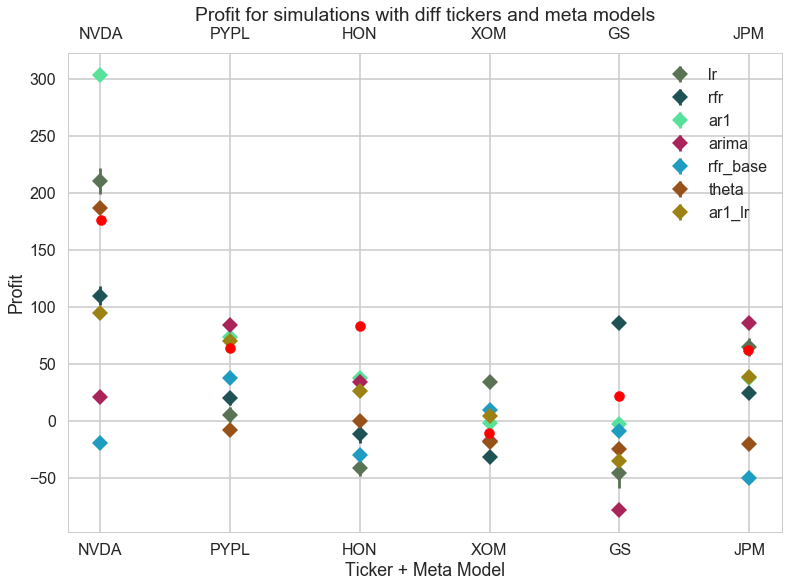

In [117]:
# vanilla_results[ticker]["lr"] = []
#     vanilla_results[ticker]["rfr"] = []
#     vanilla_results[ticker]["ar1"] = []
#     vanilla_results[ticker]["lr_weights"] = []
#     vanilla_results[ticker]["arima"] = []
#     vanilla_results[ticker]["rfr_base"] = []
#     vanilla_results[ticker]["theta"] = []
#     vanilla_results[ticker]["ar1_lr"] = []
buy_and_hold = []
vanilla_results_mean = []
vanilla_results_std = []
labels = []
final_results_mean = []
final_results_std = []
legend = ["lr", "rfr", "ar1", "arima", "rfr_base", "theta", "ar1_lr"]
results_mean = {}
results_std = {}
for label in legend:
    type_mean = []
    type_std = []
    for ticker in specified_tickers:
        type_mean.append(np.mean(np.asarray(vanilla_results[ticker][label])))
        type_std.append(np.std(np.asarray(vanilla_results[ticker][label])))
    results_mean[label] = type_mean
    results_std[label] = type_std


for ticker in specified_tickers:
    prices=training_data.loc[ticker].dropna()
    buy_and_hold.append(prices[prices.shape[0]-1] - prices[0])
#     ticker_data_mean = []
#     ticker_data_std = []
#     ticker_data_mean.append(np.mean(np.asarray(vanilla_results[ticker]["lr"])))
#     ticker_data_mean.append(np.mean(np.asarray(vanilla_results[ticker]["rfr"])))
#     ticker_data_mean.append(np.mean(np.asarray(vanilla_results[ticker]["ar1"])))
#     ticker_data_mean.append(np.mean(np.asarray(vanilla_results[ticker]["arima"])))
#     ticker_data_mean.append(np.mean(np.asarray(vanilla_results[ticker]["rfr_base"])))
#     ticker_data_mean.append(np.mean(np.asarray(vanilla_results[ticker]["theta"])))
#     ticker_data_mean.append(np.mean(np.asarray(vanilla_results[ticker]["ar1_lr"])))
#     ticker_data_std.append(np.std(np.asarray(vanilla_results[ticker]["lr"])))
#     ticker_data_std.append(np.std(np.asarray(vanilla_results[ticker]["rfr"])))
#     ticker_data_std.append(np.std(np.asarray(vanilla_results[ticker]["ar1"])))
#     ticker_data_std.append(np.std(np.asarray(vanilla_results[ticker]["arima"])))
#     ticker_data_std.append(np.std(np.asarray(vanilla_results[ticker]["rfr_base"])))
#     ticker_data_std.append(np.std(np.asarray(vanilla_results[ticker]["theta"])))
#     ticker_data_std.append(np.std(np.asarray(vanilla_results[ticker]["ar1_lr"])))
#     final_results_mean.append(ticker_data_mean)
#     final_results_std.append(ticker_data_std)
    
    labels.append(ticker)
    
fig, ax = plt.subplots()
ax2 = ax.twiny()
ax2.scatter(labels, buy_and_hold, s= 100, c='r')
ax2.grid(False)
for label in legend:
    ax.errorbar(labels, results_mean[label], yerr=results_std[label], fmt='D', c = np.random.rand(3), label=label)

ax.legend()    
# ax.errorbar(labels, final_results_mean, yerr=final_results_std, fmt='o')
ax.set_xlabel('Ticker + Meta Model')
ax.set_ylabel('Profit')
ax.set_title('Profit for simulations with diff tickers and meta models')
ax.grid(True)
plt.show()

# slide_meta_results_mean = []
# slide_meta_results_std = []
# labels = []
# for ticker in specified_tickers:
#     slide_meta_results_mean.append(np.mean(np.asarray(slide_meta_results[ticker]["lr"])))
#     slide_meta_results_mean.append(np.mean(np.asarray(slide_meta_results[ticker]["rfr"])))
#     slide_meta_results_std.append(np.std(np.asarray(slide_meta_results[ticker]["lr"])))
#     slide_meta_results_std.append(np.std(np.asarray(slide_meta_results[ticker]["rfr"])))
#     labels.append(ticker + " lr")
#     labels.append(ticker + " rfr")
    
# fig, ax = plt.subplots()
# ax2 = ax.twiny()
# ax2.scatter(labels, buy_and_hold, s= 50, c='r')
# ax.errorbar(labels, slide_meta_results_mean, yerr=slide_meta_results_std, fmt='o')
# ax.set_xlabel('Ticker + Meta Model')
# ax.set_ylabel('Profit')
# ax.set_title('Profit for simulations with sliding training for meta')
# plt.show()

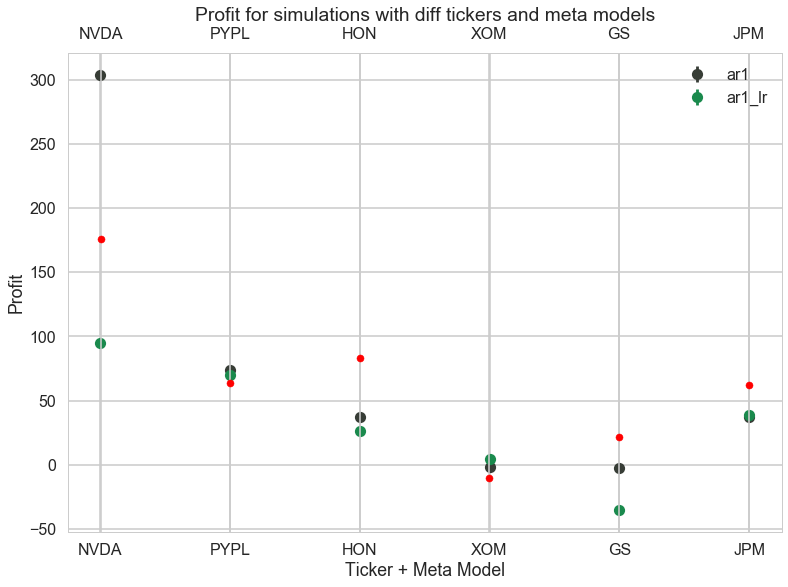

In [102]:
# SGD v/s LR
fig, ax = plt.subplots()
ax2 = ax.twiny()
ax2.scatter(labels, buy_and_hold, s= 50, c='r')
ar_sgd_legends = ["ar1", "ar1_lr"]
for label in ar_sgd_legends:
    ax.errorbar(labels, results_mean[label], yerr=results_std[label], fmt='o', c = np.random.rand(3), label=label)

ax.legend()    
# ax.errorbar(labels, final_results_mean, yerr=final_results_std, fmt='o')
ax.set_xlabel('Ticker + Meta Model')
ax.set_ylabel('Profit')
ax.set_title('Profit for simulations with diff tickers and meta models')
plt.show()

SGD seems to be comparable to, if not better than linear regression on same data. We prefer SGD over Linear Regression

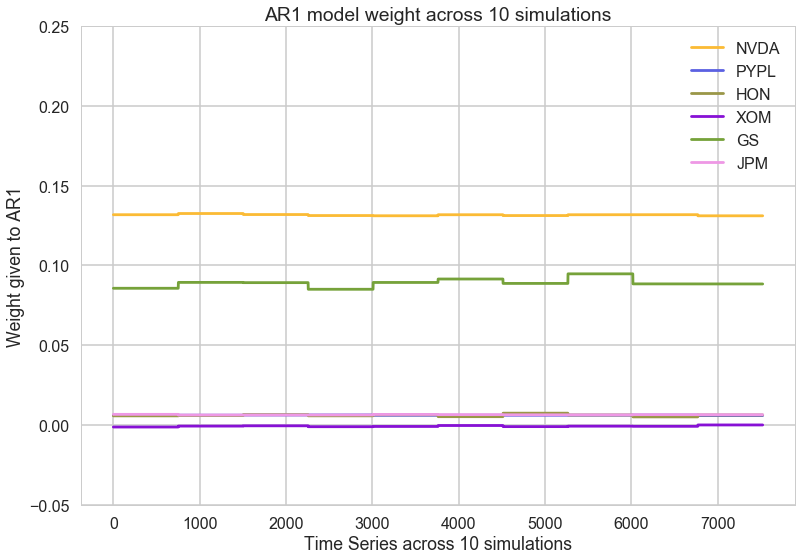

In [131]:
# predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns
ar1_weights = {}
for ticker in specified_tickers:
    ar1_weight = []
    for time in vanilla_results[ticker]["lr_weights"]:
        ar1_weight.append(time[0])
    ar1_weights[ticker] = ar1_weight
fig, ax = plt.subplots()
for ticker in specified_tickers:
    ax.plot(np.linspace(0,len(vanilla_results[ticker]["lr_weights"]), len(vanilla_results[ticker]["lr_weights"])),  ar1_weights[ticker], label=ticker, c=np.random.rand(3))
ax.legend()
ax.set_xlabel('Time Series across 10 simulations')
ax.set_ylabel('Weight given to AR1')
ax.set_title('AR1 model weight across 10 simulations')
ax.set_ylim((-0.05, 0.25))
plt.show()

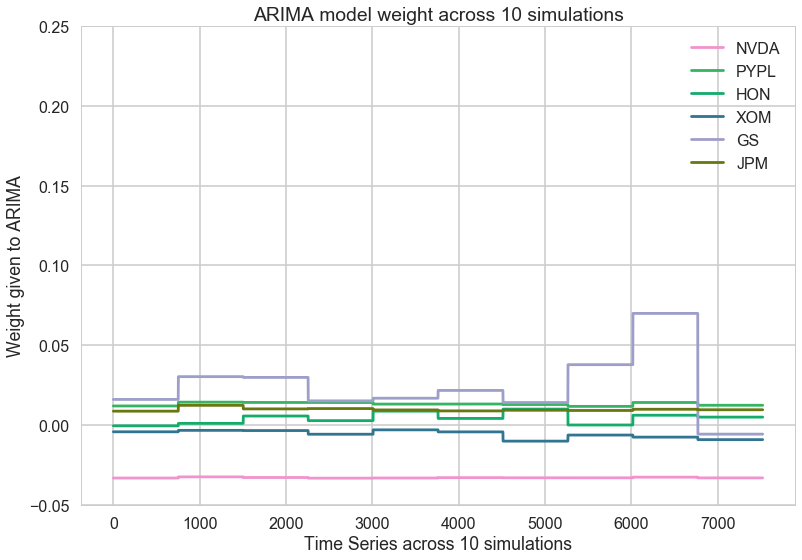

In [132]:
# predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns
arima_weights = {}
for ticker in specified_tickers:
    arima_weight = []
    for time in vanilla_results[ticker]["lr_weights"]:
        arima_weight.append(time[1])
    arima_weights[ticker] = arima_weight
fig, ax = plt.subplots()
for ticker in specified_tickers:
    ax.plot(np.linspace(0,len(vanilla_results[ticker]["lr_weights"]), len(vanilla_results[ticker]["lr_weights"])),  arima_weights[ticker], label=ticker, c=np.random.rand(3))
ax.legend()
ax.set_xlabel('Time Series across 10 simulations')
ax.set_ylabel('Weight given to ARIMA')
ax.set_title('ARIMA model weight across 10 simulations')
ax.set_ylim((-0.05, 0.25))
plt.show()

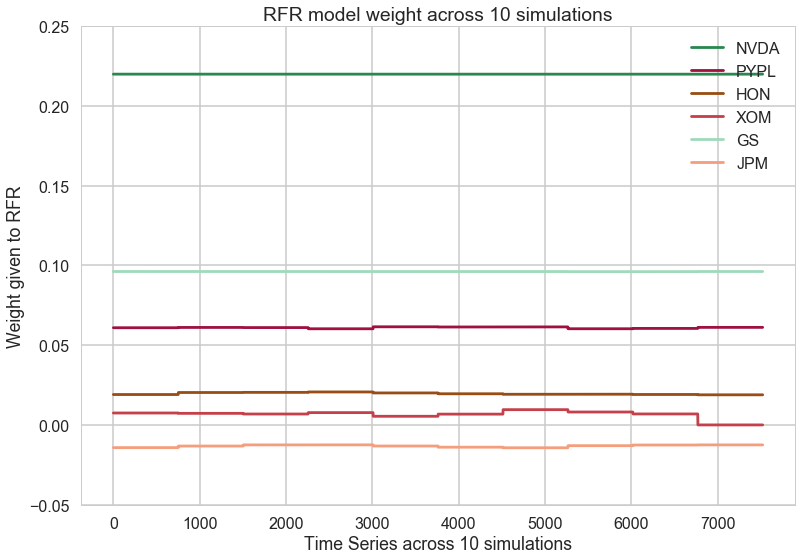

In [133]:
# predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns
rfr_weights = {}
for ticker in specified_tickers:
    rfr_weight = []
    for time in vanilla_results[ticker]["lr_weights"]:
        rfr_weight.append(time[2])
    rfr_weights[ticker] = rfr_weight
fig, ax = plt.subplots()
for ticker in specified_tickers:
    ax.plot(np.linspace(0,len(vanilla_results[ticker]["lr_weights"]), len(vanilla_results[ticker]["lr_weights"])),  rfr_weights[ticker], label=ticker, c=np.random.rand(3))
ax.legend()
ax.set_xlabel('Time Series across 10 simulations')
ax.set_ylabel('Weight given to RFR')
ax.set_title('RFR model weight across 10 simulations')
ax.set_ylim((-0.05, 0.25))
plt.show()

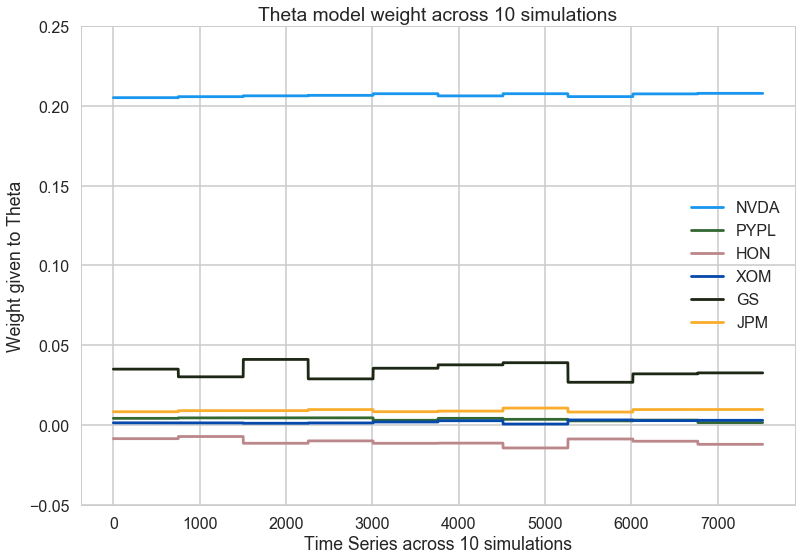

In [134]:
# predictions_ar1, predictions_arima, predictions_rfr, predictions_theta_returns
theta_weights = {}
for ticker in specified_tickers:
    theta_weight = []
    for time in vanilla_results[ticker]["lr_weights"]:
        theta_weight.append(time[3])
    theta_weights[ticker] = theta_weight
fig, ax = plt.subplots()
for ticker in specified_tickers:
    ax.plot(np.linspace(0,len(vanilla_results[ticker]["lr_weights"]), len(vanilla_results[ticker]["lr_weights"])),  theta_weights[ticker], label=ticker, c=np.random.rand(3))
ax.legend()
ax.set_xlabel('Time Series across 10 simulations')
ax.set_ylabel('Weight given to Theta')
ax.set_title('Theta model weight across 10 simulations')
ax.set_ylim((-0.05, 0.25))
plt.show()